<img src="https://i.ibb.co/hcrKx44/Weekly-Challenge-Banner.png" >

# Weekly Challenge 4
##  Description
Welcome to the 4th challenge! This week, we will see how to apply our algorithm knowledge to find ways to make money in the financial markets. *Not investment advice etc.

You are 13 weeks late on your algorithms course. You decide to sift through the videos at 10x speed.

After 1 hour of intense speedrunning, you suddenly hear the professor joking about "this is how you could theoretically make money", so you rewind the video and hear the professor say: _"The Bellman-Ford algorithm can be used by currency speculators to find arbitrages in foreign exchange (FOREX) markets."_

After a few Google searches, you gather the following definitions:

* The **[Bellman-Ford algorithm](https://en.wikipedia.org/wiki/Bellman%E2%80%93Ford_algorithm)** is used to find the shortest path from a source vertice to every other vertice.

* An **[arbitrage](https://en.wikipedia.org/wiki/Arbitrage)** is the practice of simultaneously buying and selling the same asset in different markets to profit from tiny differences in the asset's listed prices. 
    * Here's an example based on the currency graph below:
        * 1 U.S. dollar bought 0.82 Euro, 1 Euro bought 129.7 Japanese Yen, 1 Japanese Yen bought 0.12 Turkish Lira, and 1 Turkish Lira bought 0.08 U.S. dollars. 
        * Following this graph, a trader can start with 1 U.S. dollar and buy U.S. dollars, thus turning 1 USD into:
        $$0.82 \times 129.7 \times 0.12 \times 0.08 = 1.02 \;\text{USD}$$
            * The trader thus made a **2%** profit.

<img src="currency_graph.png">


## The task
You find out that in order to find an arbitrage you must find a path between the given currencies whose **product** of exchange rates is greater than 1. 

In other words, find an infinite loop from the inconsistencies in <span style='color:red'>_arbitrage_graph_</span> (the input array below) to make, on paper, infinite money.

Of course, you can also try to optimize your result by finding the **maximal** product of exchange rates in the graph (i.e., the best arbitrage).

**Hint:** 
* The Bellman-Ford algorithm is a *shortest path algorithm*. Such algorithms aim at **minimizing** the **sum** of the weights between two vertices in a graph.

## Solution
A solution is to create a directed graph in which the vertices are the currencies and the weight of the edges are the negated logarithm of the exchange rate of the currencies represented by the vertices the edge connect. For example, if exchange rate for currency $A$ to currency $B$ is $E$ then in the graph the directed edge connected $A$ to $B$ will have weight of $w_{AB} = -\ln(E)$. 

Then we can simply find whether there is a negative weight cycle.

You will find two example solutions here:
* One using networkx which finds a non-optimal arbitrage
* Another core solution that details the Bellman-Ford algorithm (**to be updated**).

In [1]:
# Find an arbitrage in the given array.
# P.S. In case you decide to use the given bellman_ford function, you'll need to replace the currency names with ints or modify the algo to run it

# USD: US dollar
# EUR: Euro
# GBP: Great Britain Pound
# CHF: Swiss franc
# CAD: Canadian dollar

arbitrage_graph = [["USD", "EUR", 0.741], ["USD", "GBP", 0.657], ["USD", "CHF", 1.061], ["USD", "CAD", 1.005],
                   ["EUR", "USD", 1.349], ["EUR", "GBP", 0.888], ["EUR", "CHF", 1.433], ["EUR", "CAD", 1.366],
                   ["GBP", "USD", 1.521], ["GBP", "EUR", 1.126], ["GBP", "CHF", 1.614], ["GBP", "CAD", 1.538],
                   ["CHF", "USD", 0.942], ["CHF", "EUR", 0.698], ["CHF", "GBP", 0.619], ["CHF", "CAD", 0.953],
                   ["CAD", "USD", 0.995], ["CAD", "EUR", 0.732], ["CAD", "GBP", 0.650], ["CAD", "CHF", 1.049]]

In [2]:
from sys import maxsize

import networkx as nx
import numpy as np

nx.__version__

'2.7.1'

In [3]:
mapping = {k: i for i, k in enumerate(set(np.array(arbitrage_graph)[:, :-1].flatten()))}
reverse_mapping = {v: k for k, v in mapping.items()}

arr = np.array([[mapping[x] if x in mapping.keys() else -np.log(x) for x in c] for c in arbitrage_graph])

G = nx.DiGraph()
G = nx.from_edgelist(list(map(tuple, arr[:, :-1])), G)
for i, (u, v) in enumerate(G.edges()):
    G[int(u)][int(v)]['weight'] = arr[i, -1]

for i in range(len(mapping)):
    neg_cycle = nx.algorithms.shortest_paths.weighted.find_negative_cycle(G, i)
    
    print(f'Negative cycle with source = {reverse_mapping[i]}:')

    print(f'Cycle: {[reverse_mapping[i] for i in neg_cycle]}')
    
    arbitrage_product = np.prod([np.exp(-G.get_edge_data(neg_cycle[i], neg_cycle[i+1])['weight']) for i in range(len(neg_cycle) -1)])
    
    print(f'Arbitrage product: {arbitrage_product} (Profit: {(arbitrage_product-1)*100:.3f}%) \n')

Negative cycle with source = USD:
Cycle: ['USD', 'EUR', 'GBP', 'USD']
Arbitrage product: 1.000830168 (Profit: 0.083%) 

Negative cycle with source = GBP:
Cycle: ['EUR', 'CHF', 'EUR']
Arbitrage product: 1.000234 (Profit: 0.023%) 

Negative cycle with source = CAD:
Cycle: ['USD', 'EUR', 'GBP', 'USD']
Arbitrage product: 1.000830168 (Profit: 0.083%) 

Negative cycle with source = EUR:
Cycle: ['USD', 'EUR', 'GBP', 'USD']
Arbitrage product: 1.000830168 (Profit: 0.083%) 

Negative cycle with source = CHF:
Cycle: ['USD', 'EUR', 'GBP', 'USD']
Arbitrage product: 1.000830168 (Profit: 0.083%) 



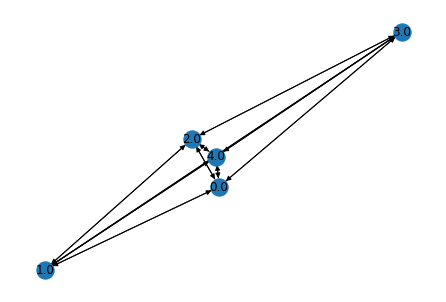

In [7]:
nx.draw(G, pos=nx.spring_layout(G), with_labels=True)

In [5]:
def find_arbitrage(graph):
    mapping = {k: i for i, k in enumerate(set(np.array(arbitrage_graph)[:, :-1].flatten()))}
    mapped_graph = [[mapping[x] if x in mapping.keys() else -np.log(x) for x in c] for c in graph]
    
    n_vertices = len(mapping)
    n_edges = len(mapped_graph)
    
    def _find_arbitrage(graph, vertices, edges, src):
        # Initialize distance of all vertices as infinite.
        dis = [maxsize] * vertices

        # initialize distance of source as 0
        dis[src] = 0

        # Relax all edges |V| - 1 times. A simple
        # shortest path from src to any other
        # vertex can have at-most |V| - 1 edges
        for i in range(vertices - 1):
            for j in range(edges):
                if dis[graph[j][0]] + graph[j][2] < dis[graph[j][1]]:
                    dis[graph[j][1]] = dis[graph[j][0]] + graph[j][2]

        # check for negative-weight cycles.
        # The above step guarantees shortest
        # distances if graph doesn't contain
        # negative weight cycle. If we get a
        # shorter path, then there is a cycle.
        for i in range(edges):
            x = graph[i][0]
            y = graph[i][1]
            weight = graph[i][2]
            if dis[x] != maxsize and dis[x] + weight < dis[y]:
                print("Graph contains negative weight cycle")

        print("Vertex Distance from Source")
        for i in range(vertices):
            print("%d\t\t%d" % (i, dis[i]))
    
    for i in range(n_vertices):
        print(f'Source: {reverse_mapping[i]}')
        _find_arbitrage(mapped_graph, n_vertices, n_edges, i)
        print()

In [6]:
find_arbitrage(arbitrage_graph)

Source: USD
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contains negative weight cycle
Vertex Distance from Source
0		0
1		0
2		0
3		0
4		0

Source: GBP
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contains negative weight cycle
Vertex Distance from Source
0		0
1		0
2		0
3		0
4		0

Source: CAD
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contains negative weight cycle
Vertex Distance from Source
0		0
1		0
2		0
3		0
4		0

Source: EUR
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contains negative weight cycle
Graph contain